In [1]:
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from smp import config

In [2]:
from smp.dataset import SegmentationDataset, Split
from smp.transform import get_train_transform, get_valid_transform
from torch.utils.data import DataLoader

transform = get_train_transform(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)
transform_valid = get_valid_transform(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)

train_dataset = SegmentationDataset(config.DATASET_PATH, Split.TRAIN, valid_size=config.VALID_SIZE, transform=transform)
valid_dataset = SegmentationDataset(config.DATASET_PATH, Split.VALID, valid_size=config.VALID_SIZE, transform=transform_valid)
test_dataset = SegmentationDataset(config.DATASET_PATH, Split.TEST, valid_size=config.VALID_SIZE, transform=transform_valid)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_dataloader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)
test_dataloader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)

Resolving data files:   0%|          | 0/1793 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1793 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1793 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

Train size: 896
Valid size: 128
Test size: 104


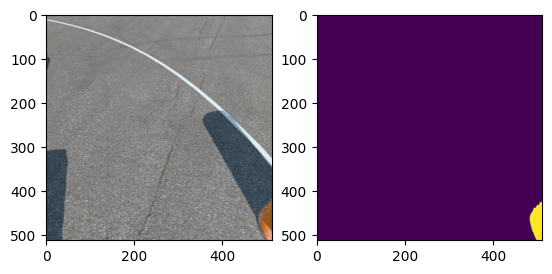

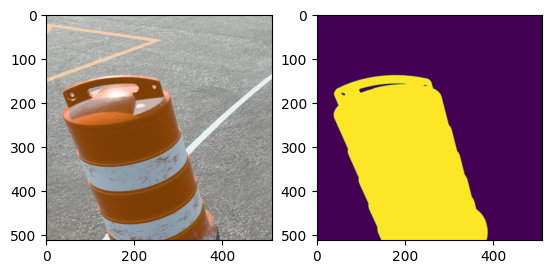

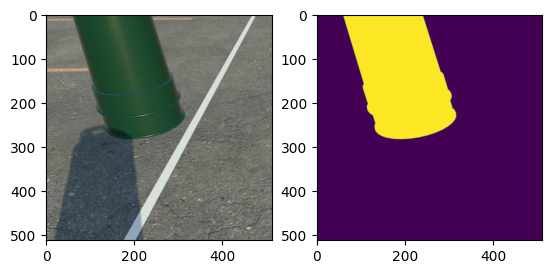

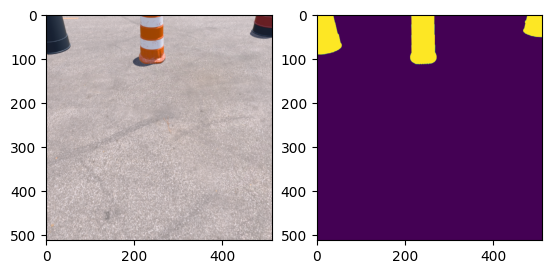

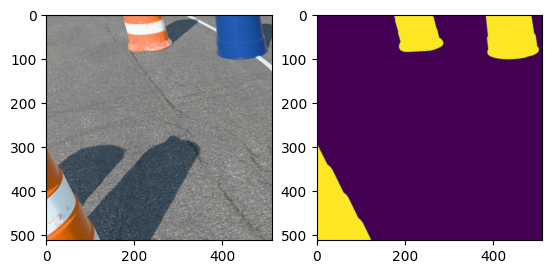

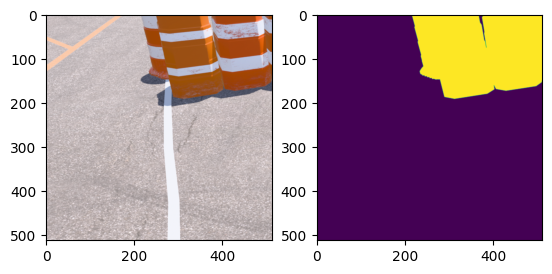

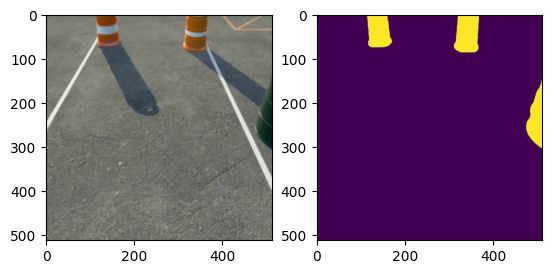

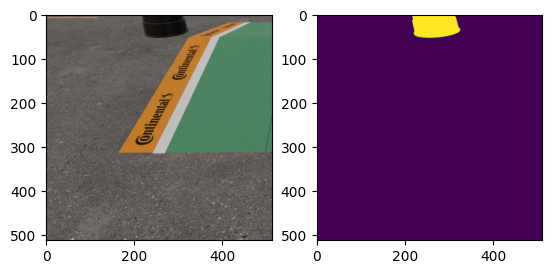

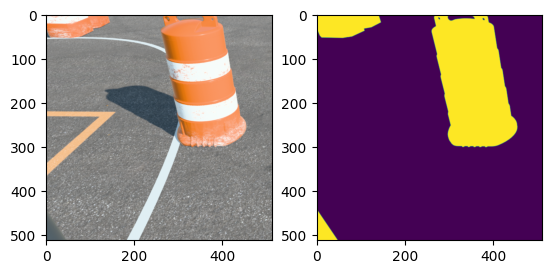

In [3]:
# lets look at some samples

def show_sample(dataset, index):
    sample = dataset[index]
    plt.subplot(1, 2, 1)
    # for visualization we have to transpose back to HWC
    plt.imshow(sample["image"].transpose(1, 2, 0))
    plt.subplot(1, 2, 2)
    # for visualization we have to remove 3rd dimension of mask
    plt.imshow(sample["mask"].transpose(1, 2, 0))
    plt.show()

# show some samples
for i in range(3):
    show_sample(train_dataset, i)
    show_sample(valid_dataset, i)
    show_sample(test_dataset, i)

In [4]:
from smp.model import SegmentationModel

T_MAX = config.NUM_EPOCHS * len(train_dataloader)

model = SegmentationModel("FPN", "resnet34", T_max=T_MAX, in_channels=3, out_classes=1)

In [5]:
trainer = pl.Trainer(max_epochs=config.NUM_EPOCHS, log_every_n_steps=1)

torch.set_float32_matmul_precision("high")

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs

In [ ]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# get original model from lightning PetModel
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
commit_info = model.model.save_pretrained(
    save_directory=config.MODEL_NAME,
    push_to_hub=False,  # optional, push model to HF Hub
    metrics=test_metrics,  # optional, save metrics in model card
    dataset=config.DATASET_NAME,  # optional, save dataset name in model card
)

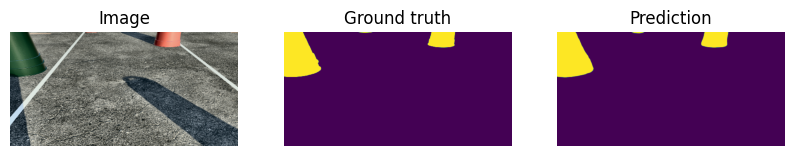

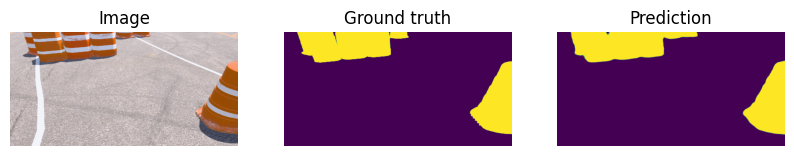

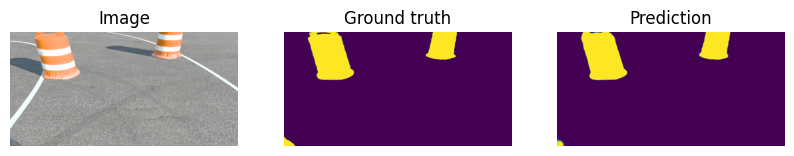

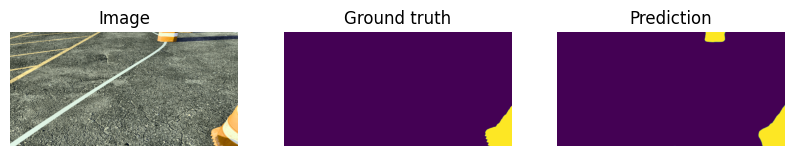

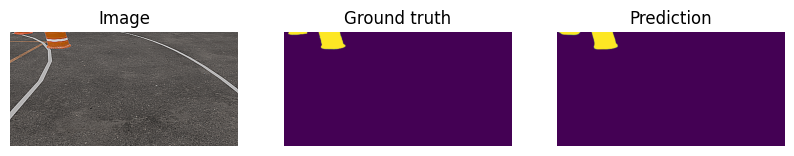

In [6]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break